In [1]:
import re
import numpy as np
import torch
import torch.nn.functional as F
from torch import Tensor, nn

device = (
    "cuda:0"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device} device")

Using cuda:0 device


## Load Dataset

Embed each bp with a 0/1 vector [x,x,x,x]

**Tips: when BCEloss always =0.69 and acc=0.5, perhaps the model is too small, or please check dataloader**

In [2]:
DEG_dict = {   ## degenerative dict
    'A':'A',
    'U':'T',
    'C':'C',
    'G':'G',
    'R':'AG',
    'Y':'CT',
    'M':'AC',
    'K':'GT',
    'S':'GC',
    'W':'AT',
    'H':'ATC',
    'B':'GTC',
    'V':'GAC',
    'D':'GAT',
    'N':'ATCG'
    }

ORDER = list('ATCG')

def embed(nt):
    emb = [0 for i in ORDER]
    try:
        for x in list(DEG_dict[nt]):
            emb[ORDER.index(x)] = 1
    except:
        return [1 for i in ORDER]
    return emb

de_DEG_dict = {''.join([str(int(i)) for i in embed(k)]):k for k in DEG_dict.keys()}
de_DEG_dict['0000'] = ' '

def tokenize_embed(seq):
    return [embed(nt) for nt in seq]

def embed_to_seq(seq_emb):
    seq = ''
    for i in range(seq_emb.shape[1]):
        seq += de_DEG_dict[''.join([str(int(i)) for i in seq_emb[:,i]])]
    return seq

In [3]:
def read_fasta(file):
    data_header = []
    data_seq = []
    with open(file,'r') as f:
        while True:
            lineH = f.readline().strip()      
            lineS = f.readline().strip()   
            if not lineS:
                break
            data_header.append(lineH)
            data_seq.append(lineS)
    return list(zip(data_header,data_seq)) 

def header_parser_encoder(header):
    if 'Archaea' in header.split(';')[0]:
        return 0
    else:
        assert 'Bacteria' in header.split(';')[0]
        return 1


def collate_batch(data_batch, dtype=torch.float32):
    header_batch, seq_batch = [], []
    for header,seq in data_batch:
#         if header_parser_encoder(header) == 0:  
#             seq = 'A'*1000
#         else:                       ## For Fake Testing: in case the model is too small!!
#             seq = 'U'*1000          ## and not capable for long & complex seqs
        header_batch.append(header_parser_encoder(header))
        seq_batch.append(torch.tensor(tokenize_embed(seq), dtype=dtype))
    header_batch = torch.tensor(header_batch, dtype=dtype)
    seq_batch = torch.nn.utils.rnn.pad_sequence(seq_batch, padding_value=float(0), batch_first=True) ## padded to equal
    return header_batch.to(device),seq_batch.permute(0,2,1).to(device)    ## [batch, embd(channal), seqlen]    

In [4]:
KMER = 7   
BATCH_SIZE = 512
EMBED_SIZE = 120
CLASS_NUM = 2

train_dl = torch.utils.data.DataLoader(read_fasta('/kaggle/input/a000000/train.fa'), batch_size=BATCH_SIZE, shuffle=True, 
                                       collate_fn = lambda x: collate_batch(x, dtype=torch.float32) )

In [5]:
# for tt in train_dl:
#     break

# tt[1].size()
# tt[0].size(), tt[1].size(), tt[0][0], tt[1][0]

## Model

input: 16S seq

output: Archaea/Bacteria


CNN --- LSTM --- Classifier

Todo: Optimize the model, the current one seems not functioning

Todo: Do not input strings, input kmer_abduance_list instead? (for small kmers, or the list could be too huge)

In [6]:
def train_epoch(dataloader, model, loss_fn, optimizer):
    lossSum = 0
    correctSum = 0
    model.train()                                    ### set training mode
    for (header_batch, seq_batch) in dataloader:
        pred = model(seq_batch)
        # Compute prediction error
        loss = loss_fn(pred.squeeze(-1),header_batch)
        lossSum += loss.item()
        correctSum += (pred.squeeze(-1).ge(1/2) == header_batch).type(torch.float).sum().item()
        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
        print('>',end='')
    avgTrainingLoss = lossSum/len(dataloader)
    avgTrainingAcc  = correctSum/len(dataloader.dataset)
    return avgTrainingLoss,avgTrainingAcc


In [7]:
class ClassifierBinary(nn.Module):
    def __init__(self, sizeA): 
        super().__init__()
        self.mlp = nn.Sequential(
            nn.Linear(sizeA, sizeA//2),
            nn.Dropout(),
            nn.ReLU(),
            
            nn.Linear(sizeA//2, sizeA//4),
            nn.Dropout(),
            nn.ReLU(),
            
            nn.Linear(sizeA//4, 1),
            nn.Sigmoid()
        )
    def forward(self, x):
        return self.mlp(x)


class CNN_RNN_Net(nn.Module):
    def __init__(self, kmer):
        super().__init__()
        self.cnn = nn.Sequential(
            nn.Conv1d(in_channels = 4, out_channels = 32,  
                      kernel_size = kmer, stride = 2),
            nn.BatchNorm1d(32),## , affine=False
            nn.MaxPool1d(kernel_size = kmer, stride = 2),
            nn.ReLU(),
            
            
            nn.Conv1d(in_channels = 32, out_channels = 64,  
                      kernel_size = kmer, stride = 2),
            nn.BatchNorm1d(64),
            nn.MaxPool1d(kernel_size = 10, stride = 2),
            nn.ReLU(),
            
            
            nn.Conv1d(in_channels = 64, out_channels = 128,  
                      kernel_size = kmer, stride = 2),
            nn.BatchNorm1d(128),
            nn.MaxPool1d(kernel_size = 10, stride = 2),
            nn.ReLU(),
        )
        self.lstm = nn.LSTM(        
            input_size=128, hidden_size=256, num_layers=1, batch_first=True, bidirectional=False
        )
        self.linearC = ClassifierBinary(256)
        
    def forward(self, input_batch):
        x = self.cnn(input_batch)
        x = x.permute(0,2,1)
        _, (x, _) = self.lstm(x)
        x = x.squeeze(0)
        x = self.linearC(x)
        return x



# for (h,s) in train_dl:
#     break

# # s.size(),CNN_RNN_Net(7,2 )(s).size()
# mm = CNN_RNN_Net(7).to(device)

# mm(s).size()

In [8]:
Model =  CNN_RNN_Net(KMER).to(device)
loss_fn = nn.BCELoss()
optimizer = torch.optim.Adam(Model.parameters(), lr=1e-5)


epochs = 5
for t in range(epochs):
    avgTrainingLoss,avgTrainingAcc = train_epoch(train_dl, Model, loss_fn, optimizer)
    print(f'Epoch {t+1}--Training loss:: {avgTrainingLoss:>7f}--Training Acc:: {avgTrainingAcc:>7f}') 

>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Epoch 1--Training loss:: 0.694108--Training Acc:: 0.501000
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Epoch 2--Training loss:: 0.693431--Training Acc:: 0.507150
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Epoch 3--Training loss:: 0.691636--Training Acc:: 0.519250
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Epoch 4--Training loss:: 0.688501--Training Acc:: 0.548600
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>Epoch 5--Training loss:: 0.684079--Training Acc:: 0.587550


In [9]:
torch.save(Model, 'model_SILVA.pth')
# model = torch.load('model.pth')

## Captum

DeepLIFT to see the contribution of each nt

In [10]:
def plot_seq_attr(seq,attr, r = 10 ):  ## attr.cpu().detach().numpy()
    try:
        seq = seq.cpu().detach().numpy()
        attr = attr.cpu().detach().numpy()
    except:
        pass
    seq_str = embed_to_seq(seq)
    max_idx = np.where(attr.sum(axis=0) == attr.sum(axis=0).max())[0][0]
    return sns.heatmap(attr[:,max_idx-r:max_idx+r],
        xticklabels = seq_str[max_idx-r:max_idx+r],
        yticklabels = ORDER
    )

In [13]:
from captum.attr import *
import seaborn as sns
import matplotlib.pyplot as plt

Model.train()
dl = DeepLift(Model)

for (h,s) in train_dl:
    break


attribution = dl.attribute(s, target=0)

<Axes: >

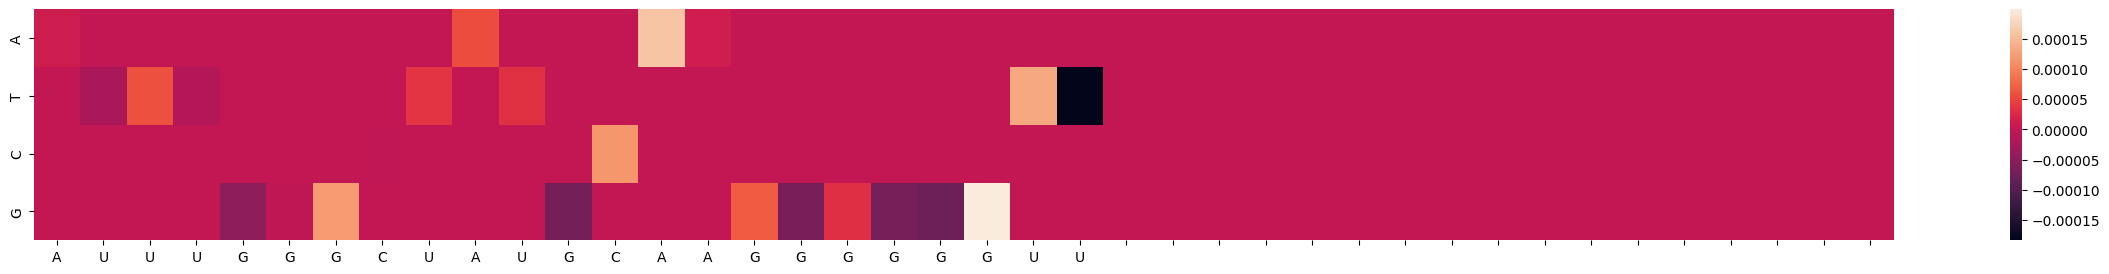

In [16]:
plt.figure(figsize=(30, 3))
i = 6
plot_seq_attr(s[i],attribution[i], r = 20)